## Predicting Stock Price
### by Wenzhe Ding

In this project we will perform time series prediction - predicting annual common stock price of U.S. - using a Recurrent Neural Network regressor. In particular, the stock price are forecasted (or predicted) 7 years in advance. 

The particular network architecture we will employ for our RNN is known as  [Long Term Short Memory (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory), which helps significantly avoid technical problems with optimization of RNNs.  

## Table of contents
- [Data Processing](#DataProcessing)
    - [Data Normalization](#Normalization)
    - [Cutting time series into sequences](#sequences)
    - [Splitting into training and testing sets](#Splitting)
- [Build an RNN regression model](#RNN)
    - [Evaluate model performance](#Evaluate)
- [Testing Out Other Time Series](#Other)
    - [Apple Stock Price](#apple)
    - [Real Estate Loans](#RealEstateLoans)

----
<a id='DataProcessing'></a>
## Data Processing
[[ go back to the top ]](#Table-of-contents)

We obtained annual common stock price data of U.S. from 1871 to 1969 [here](https://datamarket.com/data/set/22lm/annual-common-stock-price-us-1871-to-1970#!ds=22lm&display=line). 

First we must load in our time serie data - a history of around 98 years of annual common stock price.  Then we need to perform a number of pre-processing steps to prepare it for use with an RNN model.  First off, we'll normalize time series - by normalizing its range.  This helps us avoid serious numerical issues associated how common activation functions (like tanh) transform very large (positive or negative) numbers, as well as helping us to avoid related issues when computing derivatives.

Here we normalize the series to lie in the range [0,1] [using this scikit function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html), but it is also commonplace to normalize by a series standard deviation.

In [60]:
### Load in necessary libraries for data input and normalization
import pandas as pd
import numpy as np
import string
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

In [2]:
def line_plot(data, title, xlabel, ylabel):
    pplt = data.plot(marker='o', figsize=(15, 6))
    pplt.set_title(title)
    pplt.set_xlabel(xlabel, fontsize=20)
    pplt.set_ylabel(ylabel, fontsize=20)

In [3]:
### load in and normalize the dataset
raw_data = pd.read_csv('datasets/annual-common-stock-price-us-187.csv')
raw_data.head()

,Year,Annual common stock price US 1871 to 1970
0,1871,5.03
1,1872,4.80
2,1873,4.57
3,1874,4.45
4,1875,4.06


In [4]:
data = raw_data[["Annual common stock price US 1871 to 1970"]]
raw_data = raw_data.set_index("Year")

Lets take a quick look at the time series we'll be performing predictions on.

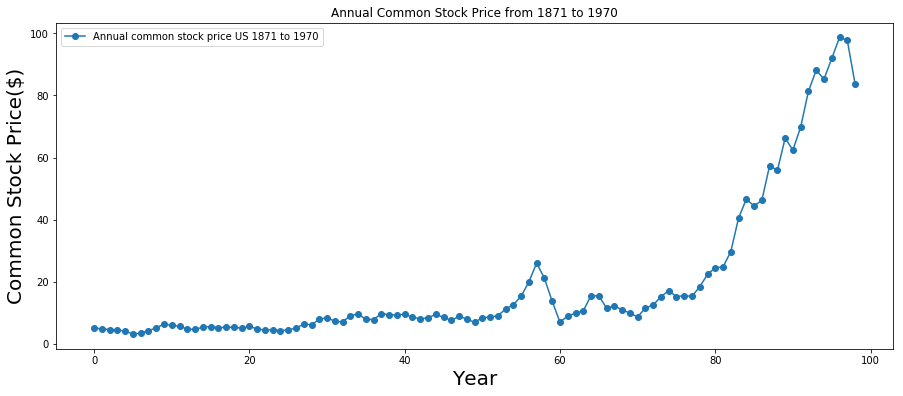

In [5]:
line_plot(data, "Annual Common Stock Price from 1871 to 1970", 'Year', 'Common Stock Price($)')

 <a id='Normalization'></a>
### Data Normalization
[[ go back to the top ]](#Table-of-contents)

In [6]:
scaler = MinMaxScaler()
data = np.array(data)
s_fit = scaler.fit(data)
norm_data = s_fit.transform(data)

In [7]:
print("Data after normalization \n")
print("Minimum Value ", norm_data.min())
print("Maximum Value ", norm_data.max())
print("Average ", norm_data.mean())
print("Standard Deviation ", norm_data.std())

Data after normalization 

Minimum Value  0.0
Maximum Value  0.9999999999999999
Average  0.17051849596847501
Standard Deviation  0.2512274525983695


 <a id='sequences'></a>
### Cutting time series into sequences
[[ go back to the top ]](#Table-of-contents)

Remember, our time series is a sequence of numbers that we can represent in general mathematically as 

$$s_{0},s_{1},s_{2},...,s_{P}$$

where $s_{p}$ is the numerical value of the time series at time period $p$ and where $P$ is the total length of the series.  In order to apply our RNN we treat the time series prediction problem as a regression problem, and so need to use a sliding window to construct a set of associated input/output pairs to regress on.  This process is animated in the gif below.

<img src="https://github.com/wzding/Artificial_Intelligence_Nanodegree/raw/master/RNN/images/timeseries_windowing_training.gif" width=600 height=600/>

For example - using a window of size T = 5 (as illustrated in the gif above) we produce a set of input/output pairs like the one shown in the table below

$$\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Notice here that each input is a sequence (or vector) of length 5 (and in general has length equal to the window size T) while each corresponding output is a scalar value.  Notice also how given a time series of length P and window size T = 5 as shown above, we created P - 5  input/output pairs.  More generally, for a window size T we create P - T such pairs. 

We implement the function called **window_transform_series** in so that it runs a sliding window along the input series and creates associated input/output pairs.    

In [8]:
def window_transform_series(series, window_size):
    # containers for input/output pairs
    X = []
    y = []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    # reshape each
    X = np.asarray(X)
    X.shape = (np.shape(X)[0:2])
    y = np.asarray(y)
    y.shape = (len(y),1)
    return X,y

Let's test our function on the list of odd numbers [1,3,5,7,9,11,13] with 2 as the window size. The result shows that our function works correctly.

In [9]:
odd_nums = np.array([1,3,5,7,9,11,13])
X,y = window_transform_series(series = odd_nums,window_size = 2)

In [10]:
print ('--- the input X is ----')
print (X)

print ('--- the output y si ----')
print (y)

--- the input X is ----
[[ 1  3]
 [ 3  5]
 [ 5  7]
 [ 7  9]
 [ 9 11]]
--- the output y si ----
[[ 5]
 [ 7]
 [ 9]
 [11]
 [13]]


With this function in place we apply it to the normalized series. We use a window_size = 7 for this exercise.

In [50]:
# window the data using your windowing function
window_size = 8
X,y = window_transform_series(series = norm_data, window_size = window_size)

 <a id='Splitting'></a>
### Splitting into training and testing sets
[[ go back to the top ]](#Table-of-contents)

In order to perform proper testing on our dataset we will lop off the last 1/3 of it for validation (or testing).  This is that once we train our model we have something to test it on (like any regression problem!).  This splitting into training/testing sets is done in the cell below.

Note how here we are **not** splitting the dataset *randomly* as one typically would do when validating a regression model.  This is because our input/output pairs *are related temporally*.   We don't want to validate our model by training on a random subset of the series and then testing on another random subset, as this simulates the scenario that we receive new points *within the timeframe of our training set*.  

We want to train on one solid chunk of the series (in our case, the first full 2/3 of it), and validate on a later chunk (the last 1/3) as this simulates how we would predict *future* values of a time series.

In [51]:
# split our dataset into training / testing sets
train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point
print("split point is", train_test_split)
# partition the training set
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# keep the last chunk for testing
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# NOTE: to use keras's RNN LSTM module our input must be reshaped to [samples, window size, stepsize] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

split point is 61


----
<a id='RNN'></a>
## Build an RNN regression model
[[ go back to the top ]](#Table-of-contents)

Having created input/output pairs out of our time series and cut this into training/testing sets, we can now begin setting up our RNN.  We use Keras to quickly build a two hidden layer RNN of the following specifications

- layer 1 uses an LSTM module with 5 hidden units (note here the input_shape = (window_size,1))
- layer 2 uses a fully connected module with one unit
- the 'mean_squared_error' loss should be used (remember: we are performing regression here)

This can be constructed using just a few lines - see e.g., the [general Keras documentation](https://keras.io/getting-started/sequential-model-guide/) and the [LSTM documentation in particular](https://keras.io/layers/recurrent/) for examples of how to quickly use Keras to build neural network models.  Make sure to initialize our optimizer given the [keras-recommended approach for RNNs](https://keras.io/optimizers/) 

In [52]:
# given - fix random seed - so we can all reproduce the same results on our default time series
np.random.seed(0)
def build_RNN(window_size):
    model = Sequential()
    model.add(LSTM(5, input_shape = (window_size,1)))
    model.add(Dense(1))
    return model

In [53]:
model = build_RNN(window_size)
# build model using keras documentation recommended optimizer initialization
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# compile the model
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [54]:
# toggle the verbose parameter, 
# which gives you regular updates on the progress of the algorithm
model.fit(X_train, y_train, epochs=1000, batch_size=60, verbose=0)

<a id='Evaluate'></a>
### Evaluate model performance
[[ go back to the top ]](#Table-of-contents)

With our model fit we can now make predictions on both our training and testing sets.

In [55]:
# generate predictions for training
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In the next cell we compute training and testing errors using our trained model. We could adjust the number of epochs you take (a maximum of around 1,000 should do the job) and/or adjusting batch_size to increase the accuracies.

In [56]:
# print out training and testing errors
training_error = model.evaluate(X_train, y_train, verbose=0)
print('training error = ' + str(training_error))

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('testing error = ' + str(testing_error))

training error = 0.000680055692562925
testing error = 0.030658336356282234


Now, we could visualize our predictions along with the original data.

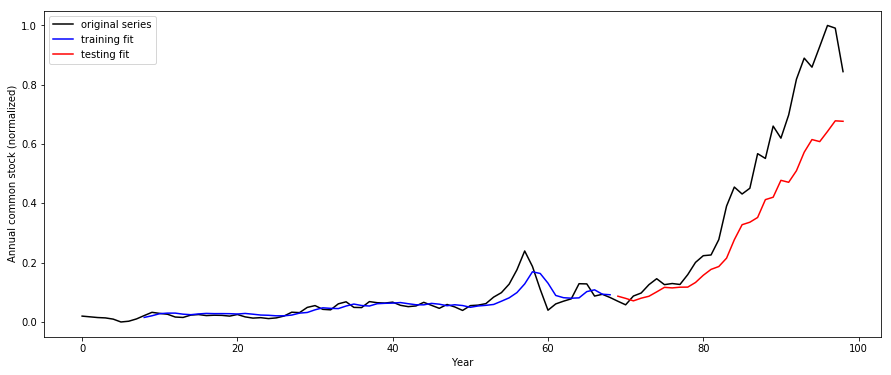

In [57]:
### Plot everything - the original series as well as predictions on training and testing sets
# plot original series
plt.figure(figsize=(15,6))
plt.plot(norm_data, color = 'k')

# plot training set prediction
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot testing set prediction
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# pretty up graph
plt.xlabel('Year')
plt.ylabel('Annual common stock (normalized)')
plt.legend(['original series','training fit','testing fit'])
plt.show()

It turns out that our model is able to capture the trend of the above time series but the prediction under estimates the common stock price after certian time period.

----
<a id='Other'></a>
## Testing Other Time Series
[[ go back to the top ]](#Table-of-contents)

Now we want to create a pipeline start from loading and processing our data to plotting the predictions so that we could use this pipeline to predict other time series.

In [61]:
class model_time_series:
    np.random.seed(0)
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
        self.scaler = MinMaxScaler()
        self.norm_data = self.X_train = self.y_train = self.X_test = self.y_test = \
        self.train_predict = self.test_predict = np.array([])
        self.train_test_split = self.split_pt = 0
        self.model = Sequential()
        
    def normalize_data(self):
        s_fit = self.scaler.fit(self.data)
        self.norm_data = s_fit.transform(self.data) 
    
    def split_data(self):
        # create sequence
        X,y = window_transform_series(series = self.norm_data, 
                                      window_size = self.window_size)
        # split data
        self.train_test_split = int(np.ceil(2*len(y)/float(3)))   # set the split point
        print("split point is", self.train_test_split)
        # partition the training set
        self.X_train = X[:self.train_test_split,:]
        self.y_train = y[:self.train_test_split]
        # keep the last chunk for testing
        self.X_test = X[self.train_test_split:,:]
        self.y_test = y[self.train_test_split:]
        self.X_train = np.asarray(np.reshape(self.X_train, 
                                             (self.X_train.shape[0], self.window_size, 1)))
        self.X_test = np.asarray(np.reshape(self.X_test, 
                                            (self.X_test.shape[0], self.window_size, 1)))
    
    def build_RNN(self):
        self.model.add(LSTM(5, input_shape=(self.window_size,1)))
        self.model.add(Dense(1))
        optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
        # compile the model
        self.model.compile(loss='mean_squared_error', optimizer=optimizer) 

    def fit_model(self):
        self.model.fit(self.X_train, self.y_train, epochs=1000, batch_size=50, verbose=0)
        
    def predict_model(self):
        self.normalize_data()
        self.split_data()
        self.build_RNN()
        self.fit_model()
        self.train_predict = self.model.predict(self.X_train)
        self.test_predict = self.model.predict(self.X_test)
    
    def plot(self, title, xlabel, ylabel):
        self.predict_model()
        plt.figure(figsize=(15,6))
        plt.plot(self.norm_data, color='k')
        # plot training set prediction
        self.split_pt = self.train_test_split + self.window_size 
        plt.plot(np.arange(self.window_size, self.split_pt, 1), 
                 self.train_predict, color='b')
        # plot testing set prediction
        plt.plot(np.arange(self.split_pt, self.split_pt + len(self.test_predict),1),
                 self.test_predict,color = 'r')
        # pretty up graph
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(['original series','training fit','testing fit'])
        plt.show()

We applied our model on historical **Daily Apply Stock Price** data and obtained predictions shown below. The result looks promising!

<a id='apple'></a>
### Apple Stock Price
[[ go back to the top ]](#Table-of-contents)

split point is 88


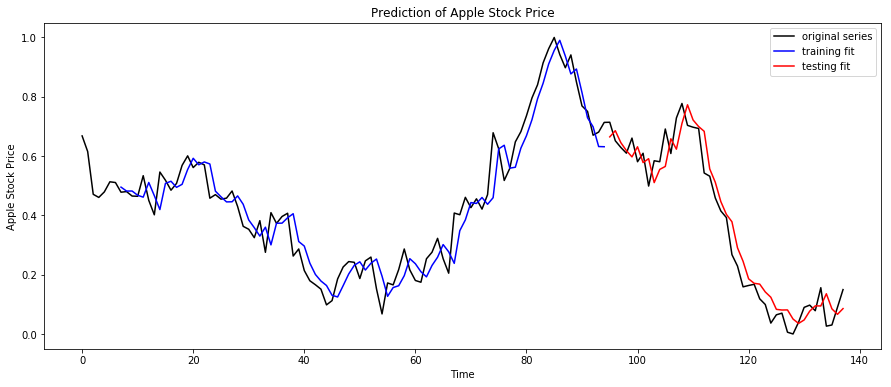

In [13]:
dataset = np.loadtxt('datasets/apple_prices.csv')
dataset = dataset.reshape(-1, 1)
m = model_time_series(dataset, 7)
m.plot("Prediction of Apple Stock Price", "Time", "Apple Stock Price")

Another example shown below is **monthly real estate loans** (billions) from Jan.1973 to Oct.1978. Again, our model's prediction underestimates real estate loans after a certarin time.

<a id='RealEstateLoans'></a>
### Real Estate Loans
[[ go back to the top ]](#Table-of-contents)

split point is 42


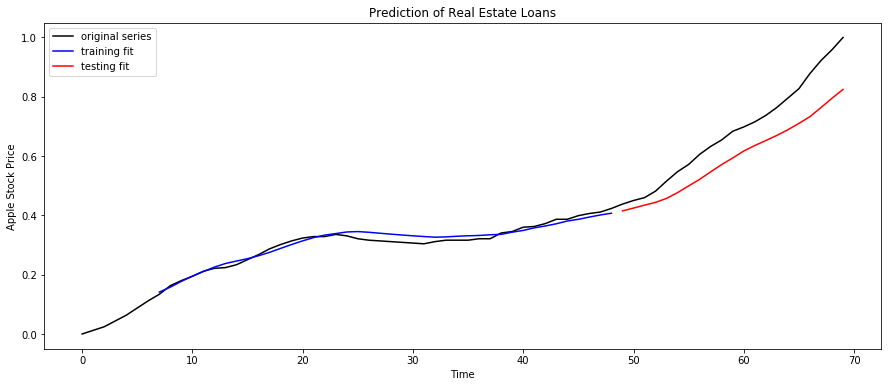

In [62]:
dataset = pd.read_csv('datasets/realestate-loans-billions-monthl.csv')
dataset = np.array(dataset["data"]).reshape(-1, 1)
m = model_time_series(dataset, 7)
m.plot("Prediction of Real Estate Loans", "Time", "Apple Stock Price")